# Traffic sign detection and classification (with deep learning)
Reset kernel

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Dependencies
Install dependencies. Adapt this to your linux distro/windows machine. Don't forget to restart the kernel to update the installed python packages.

In [2]:
%%capture
# Adapt adp-get to your distro
!pip install -U jupyter
!apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
!pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary seaborn
!pip install --upgrade --quiet jupyter_client ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Download dataset. I've created an account for this task, so please don't abuse this API key, thx.

In [ ]:
%%capture
!mkdir -p ~/.kaggle
!echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/road-sign-detection
!unzip road-sign-detection -d dataset/;

In [3]:
import cv2 as cv
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import numpy as np
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns

Define your images and annotations directory here

In [4]:
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

Load train and val images and shuffle them

In [5]:
# Get train and validation datasets

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)

#displayImage(importImage(train_images_filenames[0])), displayImage(importImage(val_images_filenames[0]))
len(train_images_filenames), len(val_images_filenames)

(613, 264)

Define functions to visualize images

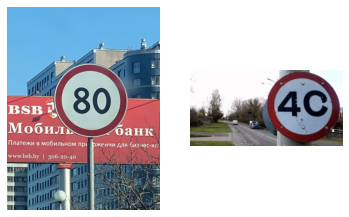

In [6]:
def importImage(name):
    from os import path
    image = cv.imread(path.join(images_directory, name + ".png"))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def displayImage(*names, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(names))
    for index, name in enumerate(names):
        axs[index].imshow(importImage(name))
        axs[index].axis('off')
    
    plt.title(title)
    plt.show()

displayImage(train_images_filenames[0], val_images_filenames[0])

## Load Dataset

For this, we define the classes that we want to predict and we define a dataset class, show bellow

In [7]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self.get_max_area_class_from_annotion(image_filename)

    def get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

Define transforms

In [8]:
def get_transform(input_size, mean, std):
    train_transform = A.Compose([
        A.RandomResizedCrop(input_size, input_size),
        A.HorizontalFlip(),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    return train_transform, val_transform


Define batch size and num workers

In [9]:
batch_size = 64
num_workers = 0 # How many processes are used to load the data

Get dataloaders according to desired image size, which will vary according to the expected input size of the network

In [10]:
def get_dataloaders(input_size, mean, std):
    train_transform, val_transform = get_transform(input_size, mean, std)
    train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

Define device

In [11]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training

We define a model trainer class, which will help us to train each model more easily. This class trains a model for a given number of epochs, keeps track of the accuracy and loss of the model accross all epochs, and can save or load the model anytime

In [57]:
MODELS_DIR = "models"

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, loss, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "loss", "optimizer"]
            model, model_name, num_epochs, loss, optimizer = [args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.curr_epoch = 0
        self.num_epochs = num_epochs # Epochs that each training session will have
        self.loss = loss
        self.optimizer = optimizer
        self.device = device
        self.accuracies = {}

    def predict_data(self, data):
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader, is_train):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            for batch, (X, y) in enumerate(tqdm(dataloader)):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                labels.extend(y.cpu().numpy())
        
        metrics = classification_report(labels, preds, output_dict=True, zero_division=0)
        return total_loss / num_batches, metrics
    
    def _save_model(self, t, file_name):
        import os
        os.makedirs(MODELS_DIR, exist_ok=True)

        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        
        save_dict = {'model': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_path)

        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        with open(acc_path, 'w') as f:
            f.write(json.dumps(self.accuracies))

    def load_model(self, file_name):
        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        dic = torch.load(model_path)
        self.model.load_state_dict(dic['model'])
        self.model.eval()
        
        with open(acc_path, 'r') as f:
            self.accuracies = json.load(f)

        print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")

    def append_history(self, stage, train_data, val_data):
        train_loss, train_metrics = train_data
        val_loss, val_metrics = val_data
        self.accuracies[stage] = {
            "train": {
                "loss": train_loss,
                "metrics": train_metrics
            },
            "val": {
                "loss": val_loss,
                "metrics": val_metrics
            },         
        }

    def reset_accuracy(self):
        self.accuracies = {}
    
    def get_best_score(self):
        def get_score(node):
            return node["val"]["metrics"]["accuracy"]
        
        m_acc, m_stage = 0, ""
        for stg in self.accuracies:
            acc = get_score(self.accuracies[stg])
            if acc > m_acc:
                m_acc = acc
                m_stage = stg
        return m_acc, m_stage

    def set_scheduler(self, scheduler, gamma):
        if scheduler != None:
            self.scheduler = scheduler(self.optimizer, gamma)

    def train(self, train_dataloader, validation_dataloader, stage):
        # Stage => String identifier of the training iteration. Is used to identify between
        # the same model being trained at different contexts (exº fine tunning)
        accuracies = []
        train_history = {'loss': [], 'accuracy': []}
        val_history = {'loss': [], 'accuracy': []}
        best_val_loss = np.inf
        print("Start training...")

        for _ in range(self.num_epochs):
            t = self.curr_epoch
            print(f"\nEpoch {t}")

            # Train
            train_loss, train_metrics = self._epoch_iter(train_dataloader, True)
            train_acc = train_metrics["accuracy"]

            print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")

            # Test
            val_loss, val_metrics = self._epoch_iter(validation_dataloader, False)
            val_acc = val_metrics["accuracy"]
            print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")
            
            # If scheduler exists, update lr
            if self.scheduler != None:
                self.scheduler.step()

            # save training history for plotting purposes
            self.append_history(
                f'{stage}_{t}',
                (train_loss, train_metrics),
                (val_loss, val_metrics)
            )

            # Save model when validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(f'{stage}_{t}', 'best_model')

            # Save latest model
            self._save_model(f'{stage}_{t}', 'latest_model')
            self.curr_epoch += 1
            
        print("Finished")

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_fc(self):
        self.model.fc.weight.requires_grad = True

    def visualize_model(self, val_dataloader, classes, num_images=6): # Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
        was_training = self.model.training
        self.model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    class_names = list(classes.keys())
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    cv.imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        self.model.train(mode=was_training)
                        return
            self.model.train(mode=was_training)

The function bellow will plot the accuracy and loss of a training session

In [13]:
def plotTrainingHistory(accuracies, session):
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    classes_pre = {c:[] for c in classes}
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["metrics"]["accuracy"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["metrics"]["accuracy"])
        for c in classes_pre:
            pre = epoch_acc["val"]["metrics"][str(classes[c])]["precision"]
            classes_pre[c].append(pre)

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')
    plt.show()

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.legend(loc='best')
    plt.show()

    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(20)
    plt.subplot(4, 1, 2)
    plt.title('Per Class Precision')
    for c in classes:  
        plt.plot(classes_pre[c], label=c)
    plt.legend(loc='best')
    plt.show()

And the function bellow will be used to try and load an existing model so that we don't have to retrain it when running the notebook

In [42]:
def load_model(trainer): # Returns True if success
    import os
    path = os.path.join(MODELS_DIR, trainer.model_name + '_best_model.pth')
    file_exists = os.path.exists(path)
    if not file_exists:
        print("Saved model not found, training instead.")
        return False
    else:
        trainer.load_model("best_model")
        return True


### ResNet-50
ResNet expects an input size of 224, and expects images to be normalized according to the following mean and std values. We use these values to retrieve the dataloaders

In [15]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std)

Charactarize training and validation sets

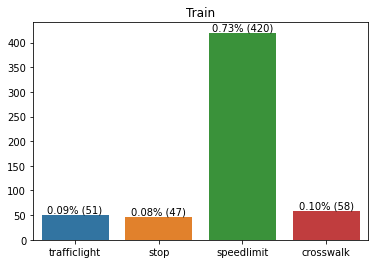

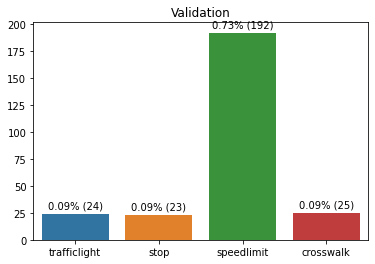

In [16]:
def describe_dataloader(dataloader, title):
    train_vals = np.array([])
    for batch, (X, y) in enumerate(dataloader):
        train_vals = np.append(train_vals, y.numpy())

    freqs = {c:np.count_nonzero(train_vals == classes[c]) for c in classes}
    keys = list(freqs.keys())
    vals = [int(freqs[k]) for k in keys]
    s = sum(vals)
    labels = [val / s for val in vals]
    labels = [f"{labels[i]:.2f}% ({vals[i]})" for i in range(len(labels))]
    ax = sns.barplot(x=keys, y=vals)
    patches = ax.patches
    ax.set_title(title)
    for i in range(len(patches)):
        x = patches[i].get_x() + patches[i].get_width()/2
        y = patches[i].get_height()+5
        ax.annotate(labels[i], (x, y), ha='center')
    plt.show()

describe_dataloader(train_dataloader, "Train"), describe_dataloader(val_dataloader, "Validation");

As can be seen, the speedlimit class is clearly the most predominant sign with the highest area across all images. This predominance is present on both validation and train sets. 

#### Transfer Learning

We define a pretrained ResNet-50 as our baseline, with 10 epochs, cross entropy loss, and SGD optimizer. We will compare all models with this one.

In [36]:
resnet_model_trained = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-2)
}

#summary(resnet["model"], (3, input_size, input_size))

First we do **transfer learning** - train only the last layer while freezing all others.

In [37]:
resnet_trainer = ModelTrainer(resnet_trained, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

# Training can be skipped by loading the best model until now
load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

plotTrainingHistory(resnet_trainer.accuracies, "frozen")

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.963 	 Train acc: 0.661


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.996 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.855 	 Train acc: 0.733


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.938 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


 11%|█         | 1/9 [00:00<00:07,  1.09it/s]


KeyboardInterrupt: 

We can see that the model can distinguish most of the speedlimit signs, while not knowing how to deal with crosswalks or trafficlights. During the last epochs the model seems to have learned how to identify stop signs.

Perform **fine tunning** - unfreeze all layers and train with a small learning rate a small number of epochs. We expect better fine tuned results after this.

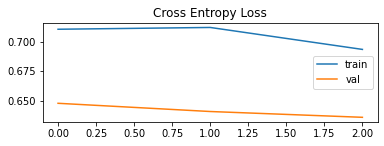

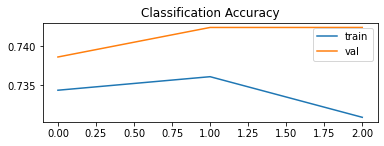

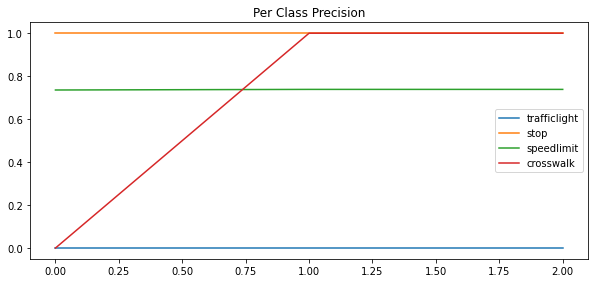

In [21]:
resnet_trainer.optimizer = torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-6)
resnet_trainer.num_epochs = 3 
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistory(resnet_trainer.accuracies, "fine_tuning")

As we can see, our best result was 0.754, which we consider satisfactory as the learning rate is fixed and we are applying few data augmentation. In addition, fine tunning has given the model the capability to distinguish crosswalk signs, but traffic lights are still not being detected.

Now let's bundle this into a function that does the transfer learning process

In [53]:
def transfer_learn(name, model,
                   opt_freeze, lr_freeze, ep_freeze,
                   opt_fine_tune, lr_fine_tune, ep_fine_tune,
                   load,
                   scheduler_freeze=None, scheduler_fine_tune=None,
                   scheduler_gamma_freeze=None, scheduler_gamma_fine_tune=None
                  ):
    # change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model.to(device)


    model_d = {
        "model": model,
        "name": name,
        #"num_epochs": 50,
        "num_epochs": ep_freeze,
        "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
        "optimizer": opt_freeze(model.parameters(), lr=lr_freeze)
    }

    trainer = ModelTrainer(model_d, device)
    trainer.set_scheduler(scheduler_freeze, scheduler_gamma_freeze)
    # Unfreeze all layers expect last
    trainer.freeze_layers()
    trainer.unfreeze_fc()

    # Training can be skipped by loading the best model until now
    if load:
        need_train = (load_model(trainer) == False)
    if not load or need_train:
        need_train = True
        trainer.train(train_dataloader, val_dataloader, "frozen")


    trainer.optimizer = opt_fine_tune(model.parameters(), lr=lr_fine_tune)
    trainer.set_scheduler(scheduler_fine_tune, scheduler_gamma_fine_tune)
    trainer.num_epochs = ep_fine_tune
    trainer.unfreeze_layers()

    if need_train: # Train if previous cell has trained too
        trainer.train(train_dataloader, val_dataloader, "fine_tuning")

    plotTrainingHistory(trainer.accuracies, "frozen")
    plotTrainingHistory(trainer.accuracies, "fine_tuning")
    return trainer


##### **Optimizer Tuning**

Now we will experiment with different optimizers and compare results

  0%|          | 0/9 [00:00<?, ?it/s]

resnet50_pretrained_adam_best_model.pth
resnet50_pretrained_adam_best_model.pth
Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.722 	 Train acc: 0.488


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Val loss: 1.424 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.259 	 Train acc: 0.628


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 1.450 	 Val acc: 0.087


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.492 	 Train acc: 0.684


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 1.213 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.070 	 Train acc: 0.719


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 1.450 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.822 	 Train acc: 0.771


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.987 	 Val acc: 0.739


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.678 	 Train acc: 0.790


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.863 	 Val acc: 0.769


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.735 	 Train acc: 0.781


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.595 	 Val acc: 0.807


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.567 	 Train acc: 0.821


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 0.579 	 Val acc: 0.814


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.624 	 Train acc: 0.816


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.974 	 Val acc: 0.822


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.703 	 Train acc: 0.786


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.625 	 Val acc: 0.826


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.586 	 Train acc: 0.825


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.569 	 Val acc: 0.841


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.553 	 Train acc: 0.837


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 0.516 	 Val acc: 0.841


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.477 	 Train acc: 0.866


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.525 	 Val acc: 0.856
Finished


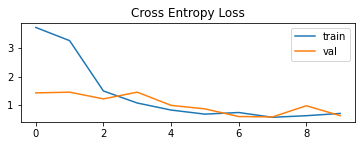

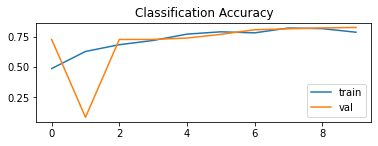

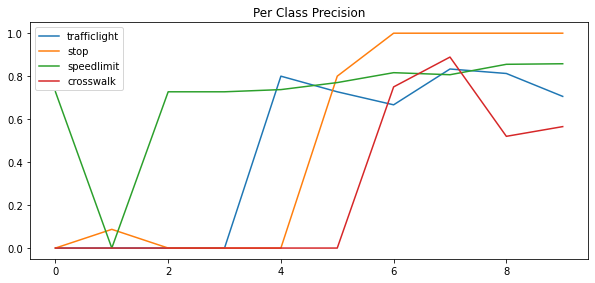

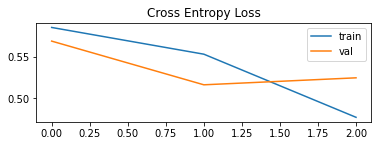

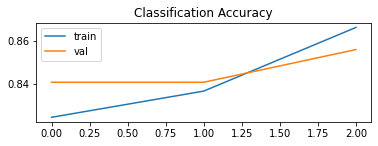

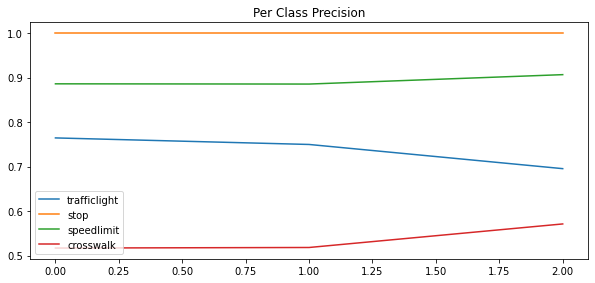

(0.8560606060606061, 'fine_tuning_12')

In [41]:
# Adam optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adam_best_score = trainer.get_best_score()
adam_best_score

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.760 	 Train acc: 0.540


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 1.026 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.573 	 Train acc: 0.693


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 1.210 	 Val acc: 0.723


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.813 	 Train acc: 0.708


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Val loss: 1.110 	 Val acc: 0.598


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.672 	 Train acc: 0.793


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 1.872 	 Val acc: 0.129


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.640 	 Train acc: 0.790


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.952 	 Val acc: 0.712


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.565 	 Train acc: 0.819


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.722 	 Val acc: 0.788


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.553 	 Train acc: 0.816


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.668 	 Val acc: 0.780


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.575 	 Train acc: 0.807


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 0.594 	 Val acc: 0.777


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.576 	 Train acc: 0.811


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 0.522 	 Val acc: 0.830


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.547 	 Train acc: 0.807


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 0.498 	 Val acc: 0.848


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.572 	 Train acc: 0.842


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 0.506 	 Val acc: 0.837


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.566 	 Train acc: 0.833


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 0.498 	 Val acc: 0.841


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.594 	 Train acc: 0.821


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Val loss: 0.505 	 Val acc: 0.837
Finished


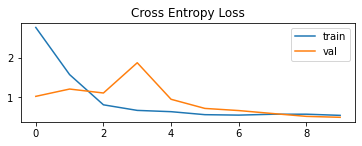

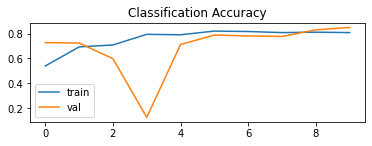

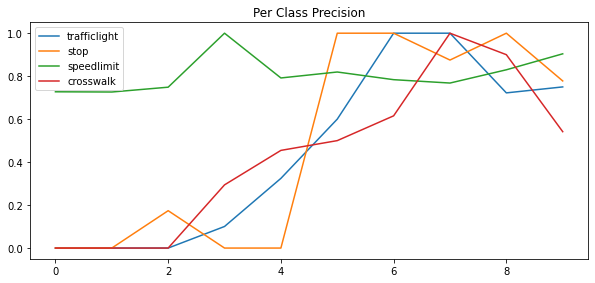

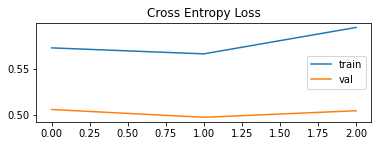

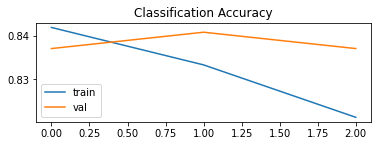

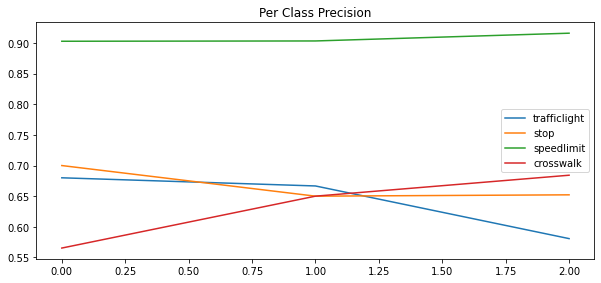

(0.8484848484848485, 'frozen_9')

In [44]:
# Adamax optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adamax",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adamax,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.Adamax,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
adamax_best_score = trainer.get_best_score()
adamax_best_score

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 27.047 	 Train acc: 0.500


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 17.264 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 17.198 	 Train acc: 0.597


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 4.524 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.092 	 Train acc: 0.630


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 8.445 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 7.262 	 Train acc: 0.611


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 7.295 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.427 	 Train acc: 0.729


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 3.273 	 Val acc: 0.227


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.219 	 Train acc: 0.635


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Val loss: 7.674 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 6.376 	 Train acc: 0.627


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Val loss: 7.725 	 Val acc: 0.250


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.439 	 Train acc: 0.700


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Val loss: 1.285 	 Val acc: 0.765


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.488 	 Train acc: 0.653


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 6.780 	 Val acc: 0.739


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.327 	 Train acc: 0.745


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 1.168 	 Val acc: 0.792


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.177 	 Train acc: 0.769


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 1.146 	 Val acc: 0.773


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.152 	 Train acc: 0.766


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Val loss: 1.202 	 Val acc: 0.792


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.058 	 Train acc: 0.774


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Val loss: 0.916 	 Val acc: 0.799
Finished


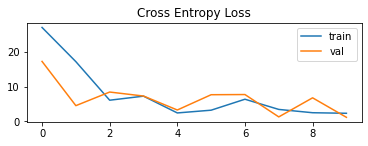

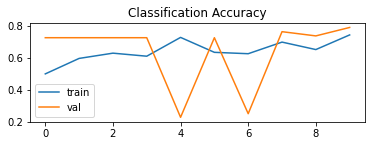

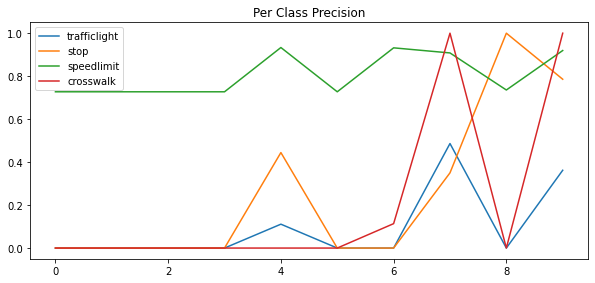

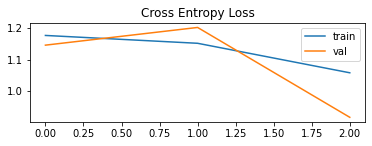

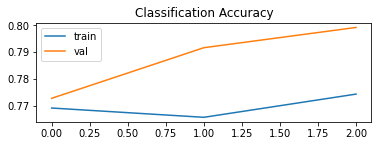

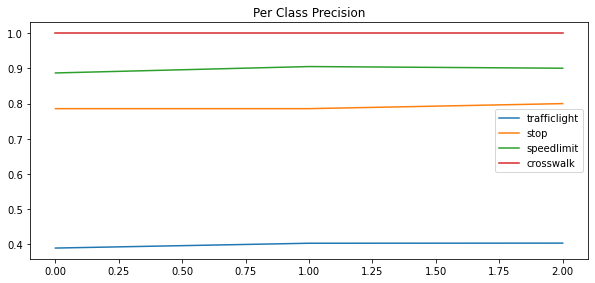

(0.7992424242424242, 'fine_tuning_12')

In [43]:
# RMSprop optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_rmsprop",
    model=resnet_model_trained,
    opt_freeze=torch.optim.RMSprop,
    lr_freeze=1e-2,
    ep_freeze=10,
    opt_fine_tune=torch.optim.RMSprop,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    load=True
)
rmsprop_best_score = trainer.get_best_score()
rmsprop_best_score

In [47]:
adam_best_score, adamax_best_score, rmsprop_best_score

((0.8560606060606061, 'fine_tuning_12'),
 (0.8484848484848485, 'frozen_9'),
 (0.7992424242424242, 'fine_tuning_12'))

As can be seen, the optimizer that provided the best results was adam. It increased accuracy from 75% to 85%.

#### **Learning Rate Scheduler**

  0%|          | 0/9 [00:00<?, ?it/s]

Saved model not found, training instead.
Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 3.475 	 Train acc: 0.521


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.370 	 Val acc: 0.727


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.426 	 Train acc: 0.677


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.475 	 Val acc: 0.091


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.110 	 Train acc: 0.651


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.013 	 Val acc: 0.663


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.658 	 Train acc: 0.793


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 1.054 	 Val acc: 0.625


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.577 	 Train acc: 0.814


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.761 	 Val acc: 0.746


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.568 	 Train acc: 0.812


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.725 	 Val acc: 0.761


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.532 	 Train acc: 0.826


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 0.556 	 Val acc: 0.814


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.458 	 Train acc: 0.837


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.576 	 Val acc: 0.784


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.519 	 Train acc: 0.835


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 0.590 	 Val acc: 0.788


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.445 	 Train acc: 0.854


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.460 	 Val acc: 0.852


  0%|          | 0/9 [00:00<?, ?it/s]

Finished
Start training...

Epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.481 	 Train acc: 0.845


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.436 	 Val acc: 0.860


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.478 	 Train acc: 0.840


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 0.418 	 Val acc: 0.864


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.471 	 Train acc: 0.839


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 0.410 	 Val acc: 0.867
Finished


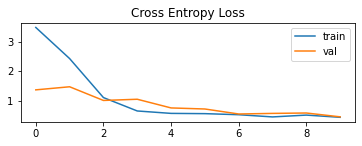

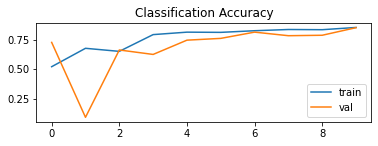

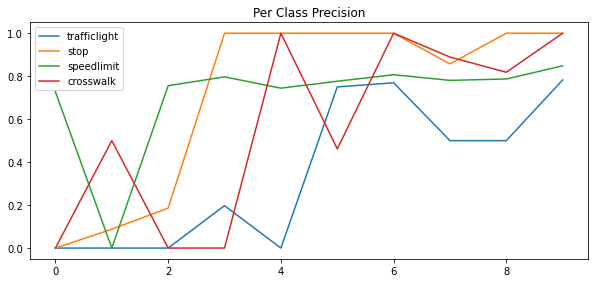

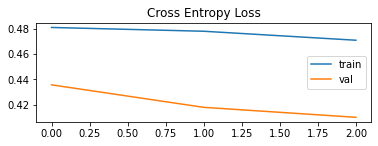

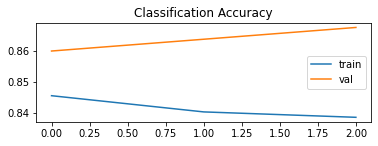

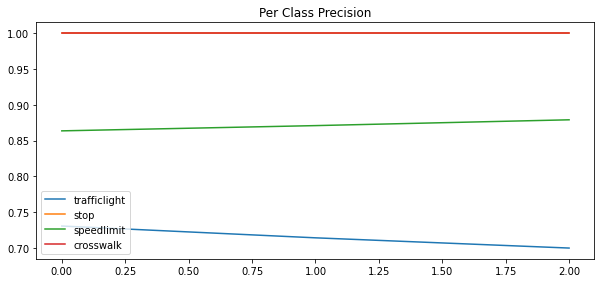

(0.8674242424242424, 'fine_tuning_12')

In [58]:
# RMSprop optimizer
resnet_model_trained = models.resnet50(pretrained=True)
trainer = transfer_learn(
    name="resnet50_pretrained_adam_expLR",
    model=resnet_model_trained,
    opt_freeze=torch.optim.Adam,
    lr_freeze=1e-2,
    ep_freeze=10,
    scheduler_freeze=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_freeze=0.9,
    opt_fine_tune=torch.optim.Adam,
    lr_fine_tune=1e-6,
    ep_fine_tune=3,
    scheduler_fine_tune=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_gamma_fine_tune=0.9,
    load=True
)
rmsprop_best_score = trainer.get_best_score()
rmsprop_best_score

In [59]:
rmsprop_best_score

(0.8674242424242424, 'fine_tuning_12')

#### Train from scratch

Now let's train the network from **scratch**, with the same hyperparams except learning rate, which was increased to get to the minima faster.

  0%|          | 0/4 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 2.436 	 Train acc: 0.416


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 1.109 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 4.896 	 Train acc: 0.555


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 1.135 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 4.132 	 Train acc: 0.549


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 1.124 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 2.262 	 Train acc: 0.564


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 1.563 	 Val acc: 0.087


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 3.316 	 Train acc: 0.404


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 3.327 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 4.735 	 Train acc: 0.557


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 2.305 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.938 	 Train acc: 0.734


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Val loss: 0.996 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 2.554 	 Train acc: 0.557


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 1.057 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.949 	 Train acc: 0.740


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Val loss: 1.003 	 Val acc: 0.727


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.982 	 Train acc: 0.559


100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


Val loss: 1.416 	 Val acc: 0.727
Finished


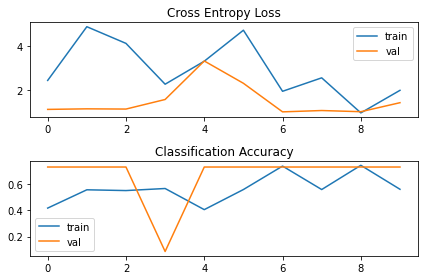

In [28]:
resnet_model_scratch = models.resnet50(pretrained=False)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_scratch.fc.in_features
resnet_model_scratch.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_scratch.to(device)

resnet_scratch = {
    "model": resnet_model_scratch,
    "name": 'resnet50_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.SGD(resnet_model_scratch.parameters(), lr=0.01)
}

resnet_trainer = ModelTrainer(resnet_scratch, device)
# Unfreeze all layers
resnet_trainer.unfreeze_layers()

load = False # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)

if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(resnet_trainer.accuracies, "scratch")

Adaptative learning rate

In [30]:
resnet_model_trained = models.resnet50(pretrained=True)

resnet_trained = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained_adam',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-2)
}

transfer_learn(resnet_trained, 3, torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-7), False)

  0%|          | 0/9 [00:00<?, ?it/s]

Start training...

Epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.339 	 Train acc: 0.297


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Val loss: 1.301 	 Val acc: 0.530


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.335 	 Train acc: 0.302


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Val loss: 1.325 	 Val acc: 0.102


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.335 	 Train acc: 0.292


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Val loss: 1.397 	 Val acc: 0.091


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.341 	 Train acc: 0.293


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Val loss: 1.326 	 Val acc: 0.167


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.342 	 Train acc: 0.290


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Val loss: 1.337 	 Val acc: 0.129


  0%|          | 0/9 [00:00<?, ?it/s]


Epoch 5


 44%|████▍     | 4/9 [00:02<00:03,  1.34it/s]


KeyboardInterrupt: 

### VGG-16

In [ ]:
# Load model from torchvision (with pretrained=True)
vgg_model = models.vgg16(pretrained=True)
# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg_model.classifier[6] = nn.Linear(4096, num_classes)
vgg_model.to(device)

vgg = {
    "model": vgg_model,
    "name": 'vgg16',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(vgg_model.parameters(), lr=1e-3)
}
print(vgg)

Only train last layers

Train from scratch

In [ ]:
vg_trainer = ModelTrainer(vgg, device)
vgg_train_history, vgg_val_history = vg_trainer.train(train_dataloader, val_dataloader)

plotTrainingHistory(vgg_train_history, vgg_val_history)